In [172]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

log_pr = pd.read_pickle("../data/log_price.df")
volu = pd.read_pickle("../data/volume_usd.df")

## Feature Engineering

In [173]:
features = log_pr.reset_index().melt(id_vars=['timestamp'])
features.columns = ['timestamp', 'stock', 'log_pr']
features = features.set_index(['timestamp', 'stock']).sort_index()

### backward returns

In [174]:
for i in [3, 5, 10, 20]:
    features['log_pr_{}'.format(i)] = -features.groupby(level='stock').log_pr.diff(i)

### log volume and volume backward diffrence

In [175]:
volu_df = volu.reset_index().melt(id_vars=['timestamp'])
volu_df.columns = ['timestamp', 'stock', 'volu']
volu_df = volu_df.set_index(['timestamp', 'stock']).sort_index()
volu_df.head(10)

volu
timestamp  stock              
2021-07-01 0      1.475069e+05
           1      5.808116e+05
           2      1.860058e+04
           3      1.601353e+05
           4      2.765960e+05
           5      2.916289e+05
           6      8.544255e+05
           7      1.801509e+05
           8      4.151507e+06
           9      7.568141e+06

In [339]:
log_fn = lambda x: np.log(x+1)
features['log_volu'] = volu_df.groupby(level='stock').volu.apply(log_fn)

In [177]:
for i in [1]:
    features['log_volu_{}'.format(i)] = features.groupby(level='stock').log_volu.diff(i)
    # features['volu_{}',format(i)] = volu_df.groupby(level='stock').volu.diff(i)

### 3 weeks Backward rolling correlation of 5 mins backward returns

[2,4,7]
[4,9]
[0,9]
[5,6]
[2,3,8]

Text(0.5, 1.0, 'Correlation Heatmap for Volatility')

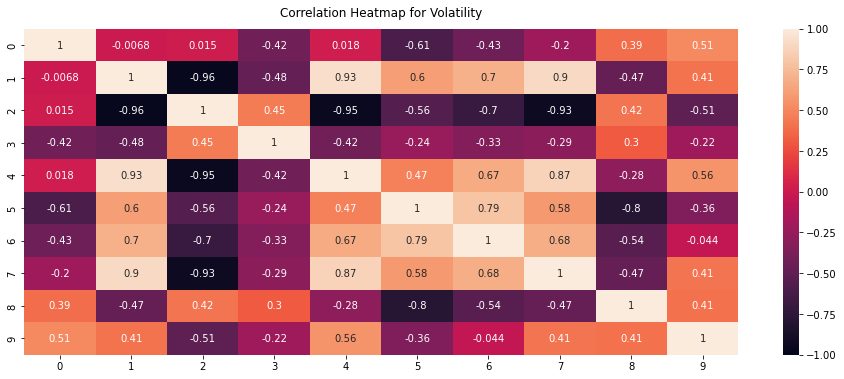

In [178]:
# plot correlation heatmap for the volatility
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(log_pr.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for Volatility', fontdict={'fontsize':12}, pad=12)

### Moving std.

In [179]:
# std_5 = lambda x: x.rolling(5).std()
std_10 = lambda x: x.rolling(10).std()
features['pr_3_std_10'] = features.groupby(level='stock').log_pr_3.apply(std_10)

In [180]:
1/2

0.5

### z score of volume

In [181]:
# roll_rank_fn = lambda x: x.rolling(240, min_period=20).apply(lambda x: pd.Series(x).rank(pct=True)[0])
zscore_fn = lambda x: (x - x.rolling(window=240, min_periods=20).mean()) / x.rolling(window=240, min_periods=20).std()
features['volu_z_score'] = volu_df.groupby(level='stock').volu.apply(zscore_fn)

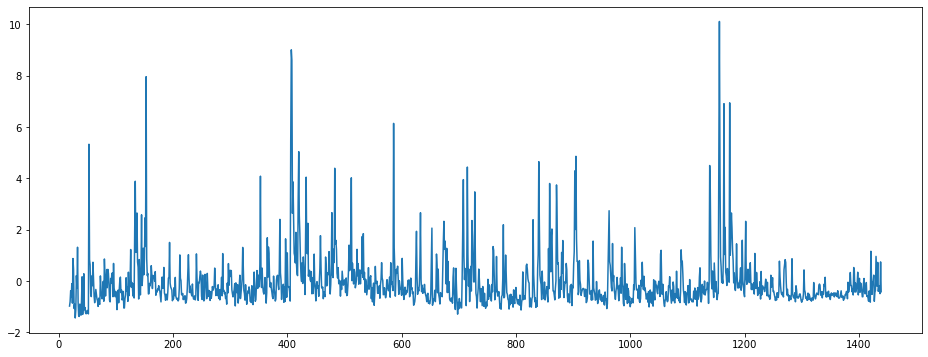

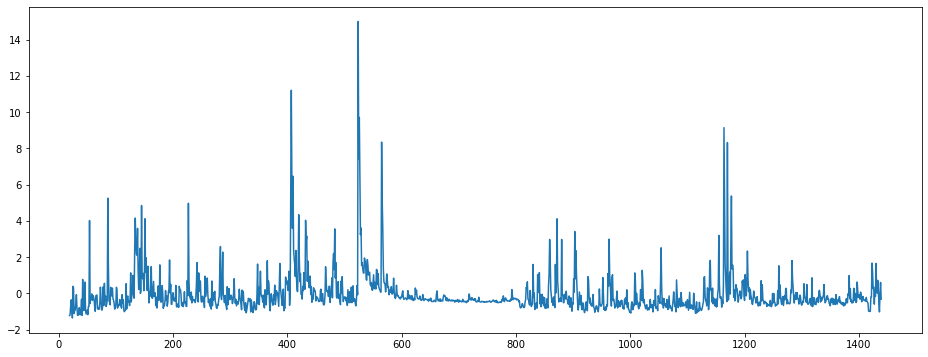

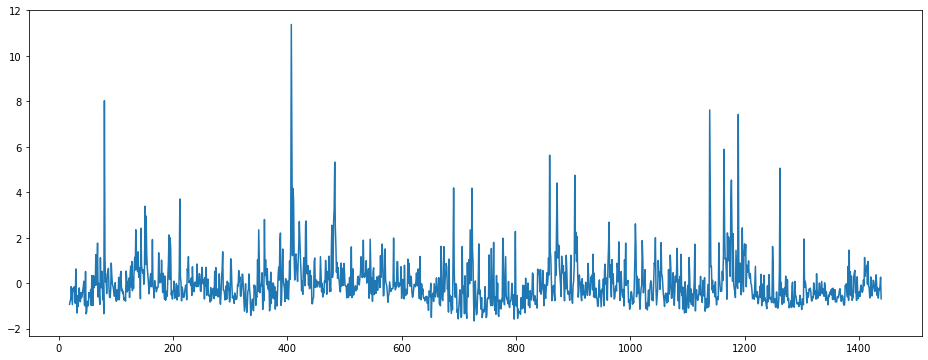

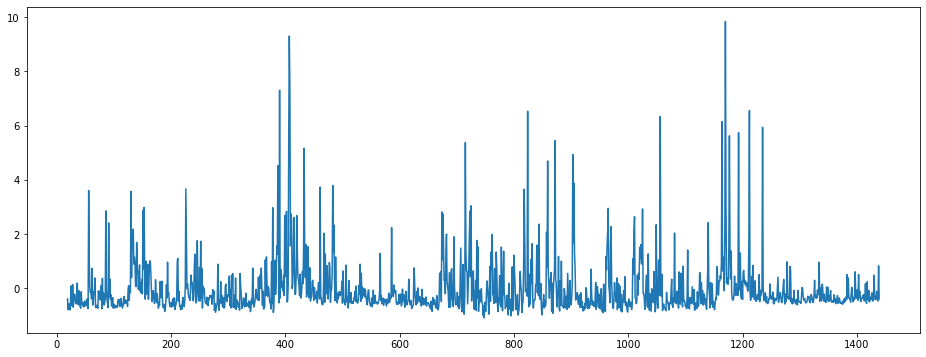

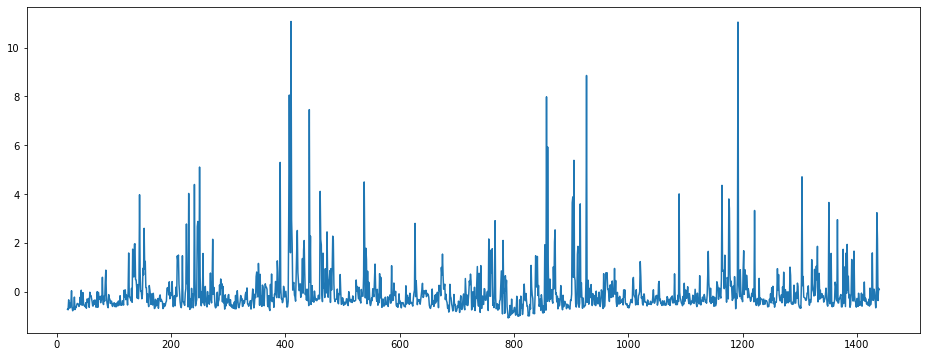

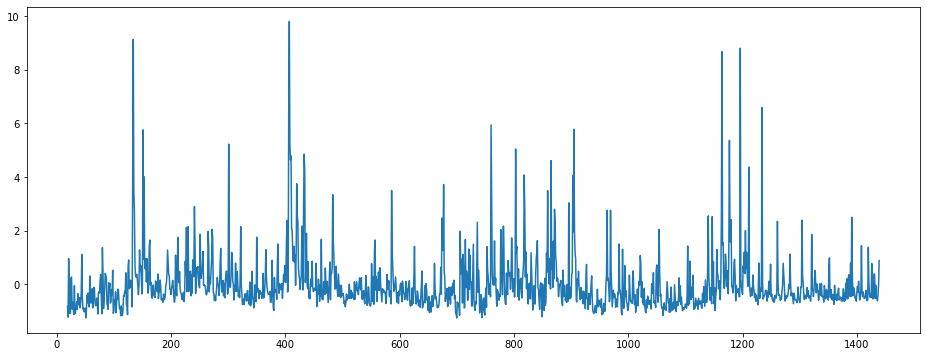

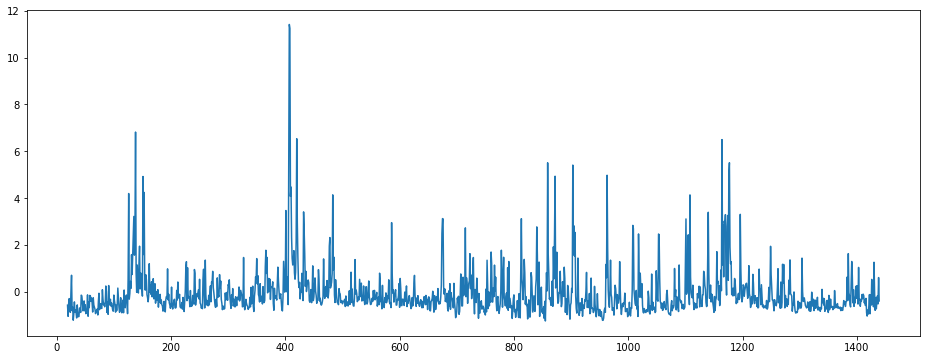

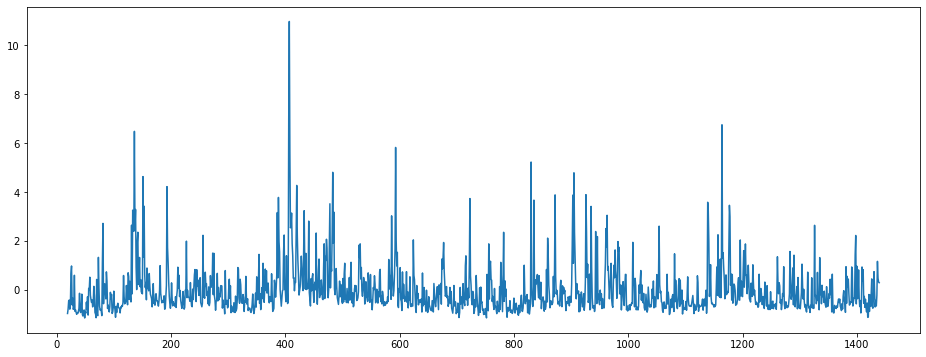

In [215]:
zscore = volu.iloc[:1440].apply(zscore_fn)

for i in range(8):
    plt.figure(figsize=(16,6))
    plt.plot(zscore.iloc[:,i].values)

### Transform back to wide format

In [182]:
feature_df = features.reset_index(level=['stock']).sort_index()

In [183]:
feature_df.head(10)

,stock,log_pr,log_pr_3,log_pr_5,log_pr_10,log_pr_20,log_volu,log_volu_1,pr_3_std_10,volu_z_score
timestamp,,,,,,,,,,
2021-07-01,0,0.000051,NaN,NaN,NaN,NaN,11.901630,NaN,NaN,NaN
2021-07-01,1,-0.002754,NaN,NaN,NaN,NaN,13.272182,NaN,NaN,NaN
2021-07-01,2,-0.001690,NaN,NaN,NaN,NaN,9.830948,NaN,NaN,NaN
2021-07-01,3,-0.000106,NaN,NaN,NaN,NaN,11.983774,NaN,NaN,NaN
2021-07-01,4,0.002195,NaN,NaN,NaN,NaN,12.530313,NaN,NaN,NaN
2021-07-01,5,0.000217,NaN,NaN,NaN,NaN,12.583238,NaN,NaN,NaN
2021-07-01,6,-0.001661,NaN,NaN,NaN,NaN,13.658185,NaN,NaN,NaN
2021-07-01,7,0.000492,NaN,NaN,NaN,NaN,12.101550,NaN,NaN,NaN
2021-07-01,8,-0.000917,NaN,NaN,NaN,NaN,15.238982,NaN,NaN,NaN


In [228]:
temp = feature_df.pivot(columns ='stock')
temp.columns = temp.columns.get_level_values(0) + '_' +  [str(x) for x in temp.columns.get_level_values(1)]

In [195]:
temp.iloc[20:].isnull().any().all()

False

### Organize Code

In [216]:
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean(0)
    iqr = dta.quantile([0.25, 0.75], axis=0).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

In [396]:
def wide_format(df):
    df_= df.reset_index(level=['stock']).sort_index()
    df_ = df_.pivot(columns ='stock')
    df_.columns = df_.columns.get_level_values(0) + '_' +  [str(x) for x in df_.columns.get_level_values(1)]

    return df_


def get_feature_train(log_pr, volu, x_begin_idx, x_end_idx, y_begin_idx, 
                        grp_idx=None, rm_outlier=False, print_cor=True):
    """
    Input:
    log_pr (pdSeries): train set
    volu (pdSeries): train set
    x_begin_idx (pdIndex): to truncate the NaNs
    grp_idx (dict): key is group idx, value is list of stock idx

    Returns:
    feature_dict (dict): key is group idx, value is a tuple of feature matrix and response
    """

    log_pr_df = log_pr.reset_index().melt(id_vars=['timestamp'])
    log_pr_df.columns = ['timestamp', 'stock', 'log_pr']
    log_pr_df = log_pr_df.set_index(['timestamp', 'stock']).sort_index()

    volu_df = volu.reset_index().melt(id_vars=['timestamp'])
    volu_df.columns = ['timestamp', 'stock', 'volu']
    volu_df = volu_df.set_index(['timestamp', 'stock']).sort_index()

    features = pd.DataFrame(index=log_pr_df.index)
    # log_pr feature
    for i in [3, 10, 20, 30]:
        features['log_pr_{}'.format(i)] = -log_pr_df.groupby(level='stock').log_pr.diff(i)

    std_10 = lambda x: x.rolling(10).std()
    features['log_pr_std_10'] = log_pr_df.groupby(level='stock').log_pr.apply(std_10)

    # volume feature
    log_fn = lambda x: np.log(x+1)
    features['log_volu'] = volu_df.groupby(level='stock').volu.apply(log_fn)

    # stdised volume in 2 hours backward rolling windows
    zscore_fn = lambda x: (x - x.rolling(window=240, min_periods=20).mean()) / x.rolling(window=240, min_periods=20).std()
    features['volu_z_score'] = volu_df.groupby(level='stock').volu.apply(zscore_fn)

    # feature_dropped = features.iloc[x_begin_idx:x_end_idx]
    response = log_pr.diff(30)
    # print(features.shape)
    # print(feature_dropped.shape)
    # print(response_dropped.shape)

    if grp_idx is not None:
        feature_dict = {}
        for key, idx_lis in grp_idx.items():
            feature_df_dropped = wide_format(features.loc[pd.IndexSlice[:,idx_lis],:])
            # transform back to wide format
            feature_dict[key] = (feature_df_dropped.iloc[x_begin_idx:x_end_idx], 
                                            response[idx_lis].iloc[y_begin_idx:])
        return feature_dict
    else:
        # transform back to wide format
        feature_df_dropped = wide_format(features).iloc[x_begin_idx:x_end_idx]
        # feature_df_dropped = feature_df[x_begin_idx:x_end_idx]
    
        if print_cor:
            for i in range(10):
                feature_train_0 = features.xs(i, level='stock')
                print(feature_train_0.corrwith(response[i]))

        return feature_df_dropped, response.iloc[y_begin_idx:]

In [430]:
def wide_format_test(df):
    df_= df.reset_index()
    df_ = df_.pivot(columns ='index').apply(lambda s: s.dropna().reset_index(drop=True))
    df_.columns = df_.columns.get_level_values(0) + '_' +  [str(x) for x in df_.columns.get_level_values(1)]

    return df_

def get_feature_test(log_pr, volu, grp_idx=None):
    """
    Input: 
    log_pr (pdSeries): 1 day of log pr 
    volu (pdSeries): 1 day of volume

    Output:
    test data frame
    """
    features = pd.DataFrame(index=log_pr.columns)

    # backward return
    # print(-(log_pr.iloc[-1] - log_pr.iloc[-30]).values)
    for i in [10, 20, 30]:
        features['log_pr_{}'.format(i)] = -(log_pr.iloc[-1] - log_pr.iloc[-i]).values
    # backward rolling std
    features['log_pr_std_10'] = log_pr.iloc[-10:].std(0).values
    
    # volume features
    features['log_volu'] = np.log(volu.iloc[-1].values + 1)
    features['volu_z_score'] = ((volu.iloc[-1] - volu.iloc[-240:].mean())/volu.iloc[-240:].std()).values

    if grp_idx is None:
        return wide_format_test(features)
    else:
        df_dict = {}
        for key, idx_lis in grp_idx.items():
            df_dict[key] = wide_format_test(features.loc[idx_lis])
        return df_dict


In [ ]:
       # if rm_outlier:
        #     feature_df_dropped = remove_outliers(feature_df)
        #     na_idx = feature_df_dropped.isnull().any(1)
        #     response_dropped[na_idx] = np.nan

        #     return feature_df_dropped.dropna(), response_dropped.dropna()

In [397]:
t_train = log_pr.index[-87841]
log_pr_train = log_pr[:t_train]
volu_train = volu[:t_train]

x_begin_idx = 30
x_end_idx = -30
y_begin_idx = 60

grp_idx = {0:[1,5,6,8], 1:[2,4,7], 2:[0,3,9]}
feature_dict = get_feature_train(log_pr_train, volu_train, x_begin_idx, x_end_idx, y_begin_idx, grp_idx)

In [428]:
feature_dict = get_feature_test(log_pr, volu, grp_idx)

In [429]:
feature_dict.get(0)

,log_pr_10_1,log_pr_10_5,log_pr_10_6,log_pr_10_8,log_pr_20_1,log_pr_20_5,log_pr_20_6,log_pr_20_8,log_pr_30_1,log_pr_30_5,...,log_pr_std_10_6,log_pr_std_10_8,log_volu_1,log_volu_5,log_volu_6,log_volu_8,volu_z_score_1,volu_z_score_5,volu_z_score_6,volu_z_score_8
0,-0.001684,0.001316,-0.001814,-0.000663,-0.000642,0.000717,-0.002061,-0.000214,-0.000942,0.000161,...,0.001587,0.000229,12.972286,13.322706,13.542142,15.3577,1.545912,0.942045,0.535441,0.674985
